# Computer Vision Masterclass - Face Other Algorithm

## Dlib

In [23]:
import dlib
import cv2
from google.colab.patches import cv2_imshow
import zipfile
import os
import numpy as np
from PIL import Image
import random
from sklearn.metrics import accuracy_score

### Detecting facial points

In [2]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
image = cv2.imread('people2.jpg')

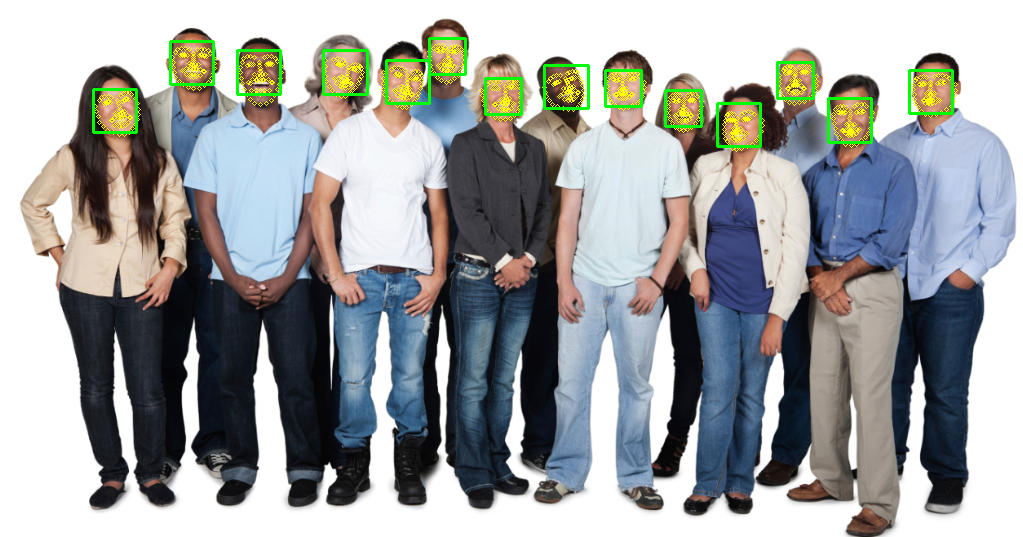

In [4]:
face_detection = face_detector(image, 1)
for face in face_detection:
  points = points_detector(image, face)
  for point in points.parts():
    cv2.circle(image, (point.x, point.y), 2, (0, 255, 255), 1)

  l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
  cv2.rectangle(image, (l, t), (r, b), (0, 255, 0), 2)

cv2_imshow(image)

### Detecting facial descriptors

In [5]:
path = 'yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [6]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('dlib_face_recognition_resnet_model_v1.dat')

In [7]:
index = {}
idx = 0
face_descriptors = None # Will be numpy array that contains image features.

paths = [os.path.join('yalefaces/train', f) for f in os.listdir('yalefaces/train')]
for path in paths:
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (0, 0, 255), 2)

    points = points_detector(image_np, face)
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    face_descriptor = [f for f in face_descriptor] # represent information of each faces.
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]

    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis=0)
    
    index[idx] = path
    idx += 1

  cv2_imshow(image_np)

Output hidden; open in https://colab.research.google.com to view.

In [8]:
face_descriptors.shape

(132, 128)

### Calculating the distance between faces

In [9]:
rand_num1 = random.randint(0, len(index))
rand_num2 = random.randint(0, len(index))
print('index:', rand_num1, ',', rand_num2)
print('distance:', np.linalg.norm(face_descriptors[rand_num1] - face_descriptors[rand_num2])) # This means the lower the value(distance), the higher similarity between two faces.

index: 88 , 99
distance: 0.9154306922432458


In [10]:
np.linalg.norm(face_descriptors[len(index)-1] - face_descriptors, axis=1) # Compare one image to all the other images in the dataset

array([0.82344972, 0.81532723, 0.77469479, 0.85573156, 0.927584  ,
       0.83057343, 0.75166822, 0.65246998, 0.6374043 , 0.78667714,
       0.92624788, 0.6273318 , 0.97180563, 0.65759853, 0.88348991,
       0.73504369, 0.6060407 , 0.80986431, 0.89924168, 0.83463152,
       0.30736473, 0.73680222, 0.83337449, 0.78924085, 0.8538639 ,
       0.6979541 , 0.829753  , 0.6265588 , 0.6314625 , 0.85599143,
       0.95414698, 0.80902383, 0.8418162 , 0.74664545, 0.79091216,
       0.91069249, 0.74176572, 0.87317587, 0.72487089, 0.7142066 ,
       0.66958991, 0.69862626, 0.75448918, 0.669567  , 0.87902848,
       0.78762576, 0.35511092, 0.91002852, 0.8699667 , 0.85840988,
       0.69384162, 0.67191203, 0.75019911, 0.71480334, 0.64041773,
       0.79965209, 0.70799859, 0.5833019 , 0.70897818, 0.85037562,
       0.89004964, 0.69543706, 0.89084587, 0.79763291, 0.63895377,
       0.92624788, 0.618431  , 0.98628205, 0.64411783, 0.7057705 ,
       0.73622033, 0.76835257, 0.79128643, 0.64755661, 0.65238

In [11]:
(np.argmin(np.linalg.norm(face_descriptors[0] - face_descriptors[1:], axis=1)) + 1) # Returns an index with a minimum value

1

### Detecting faces with Dlib

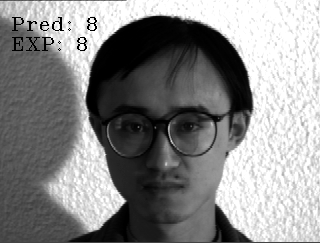

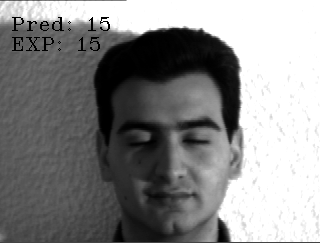

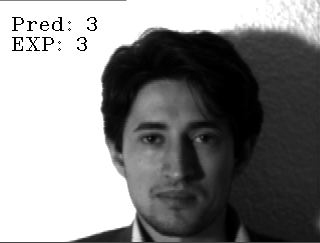

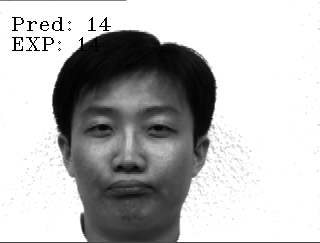

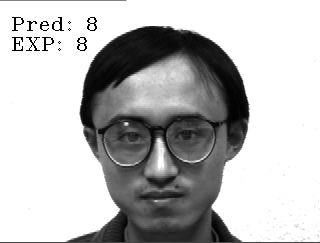

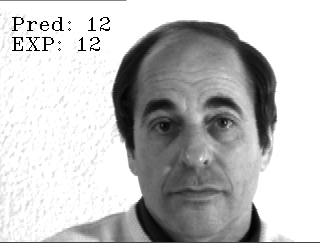

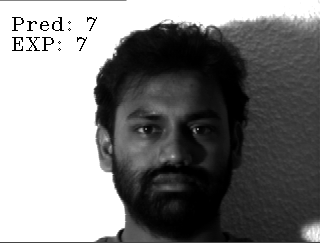

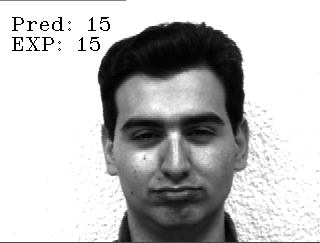

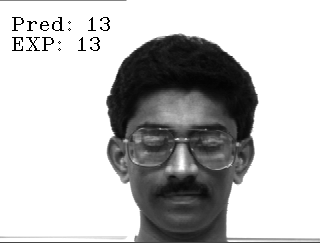

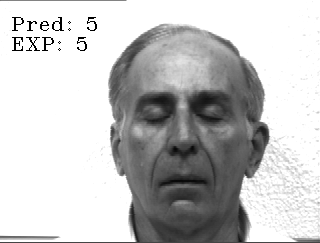

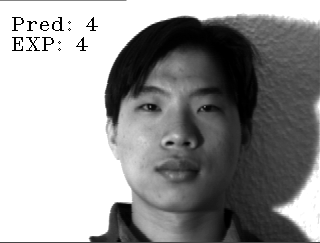

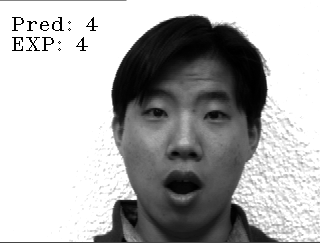

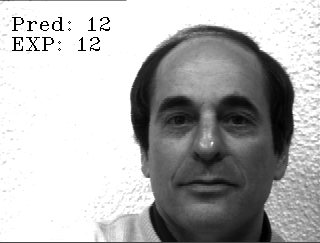

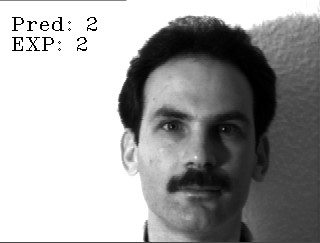

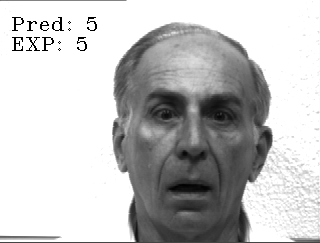

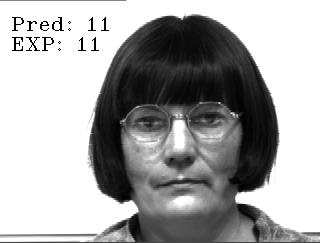

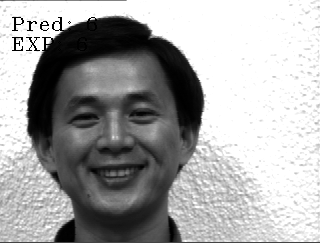

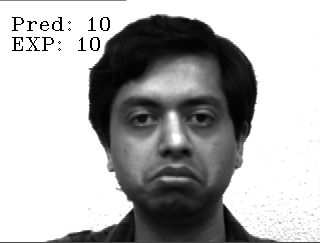

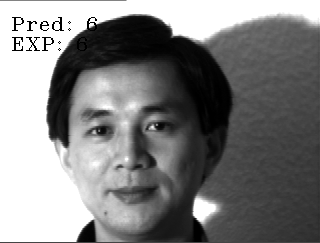

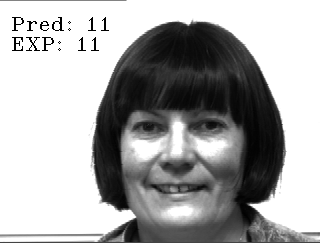

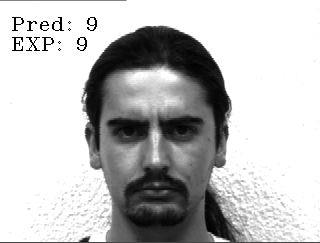

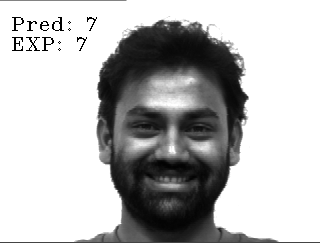

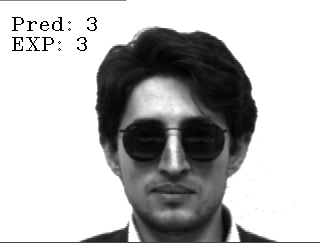

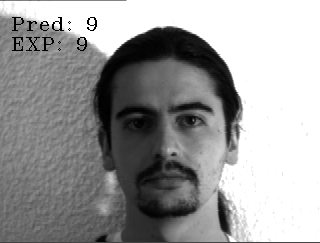

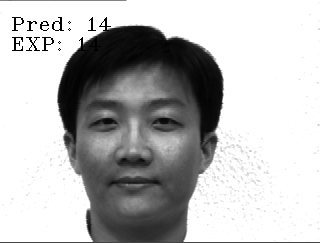

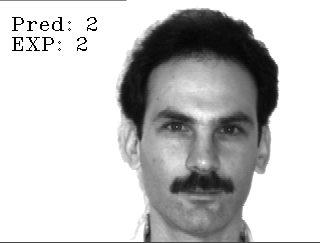

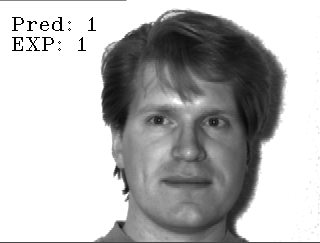

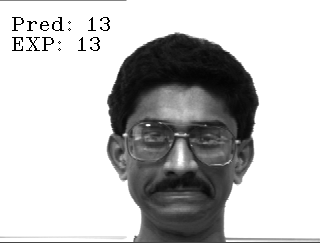

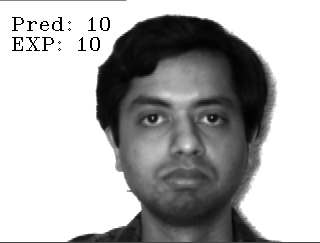

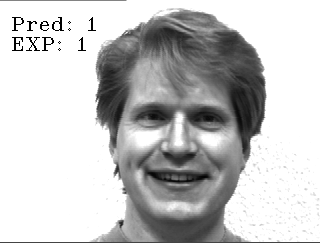

In [25]:
threshold = 0.5
predictions = []
expected = []

paths = [os.path.join('yalefaces/test', f) for f in os.listdir('yalefaces/test')]
for path in paths:
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    points = points_detector(image_np, face)
    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    face_descriptor = [f for f in face_descriptor]
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    face_descriptor = face_descriptor[np.newaxis, :]

    distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
    min_index = np.argmin(distances)
    min_distance = distances[min_index]

    if min_distance <= threshold:
      name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
    else:
      name_pred = 'Not identified'

    name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

    predictions.append(name_pred)
    expected.append(name_real)

    cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0))
    cv2.putText(image_np, 'EXP: ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 0))


  cv2_imshow(image_np)

In [26]:
predictions = np.array(predictions)
expected = np.array(expected)
accuracy_score(expected, predictions)

1.0